З по итогам лекции 12.

ДЗ - в рамках ранее выполненной работы по обработке данных c помощью pandas (учебный файл с данными credit_train.csv), выполнить все работы с пандас дата фреймом через SQL запросы.

разбить выборку на обучающую и тестовую
проанализировать пропуски и решить, что с ними делать
проанализировать выбросы
создать/ удалить переменные
закодировать категориальные переменные
нормализовать числовые переменные (при необходимости)
Сама эта ранее выполненная работа включала следующие задания credit_train.csv - файл данных Подготовить данные для модели:

Анализ данных, необходимые корректировки.

Обработать пропуски.
Оценить выбросы.
Корреляция.
Тест на нормальность распределения.
Масштабировать данные.
В прошлый раз проделывалось следующее: после загрузки файла данных, представленного в формате csv, в датафрейм модуля pandas. *) Далее следует провести поиск пропусков и удалить строки с пропусками. *) Кроме того, предварительный анализ файла данных показывает, что колонка living region содержит много дублей типа "московская обл" и "обл московская" или "чеченская республика" и "чеченская респ". Придется поработать с данными этой колонки, чтобы привести систему обозначений регионов к однозначной. Поскольку регионов слишком много, что затруднит анализ корреляции данных, то мы приведем всю систему к федеральным округам и двум столицам - Москва и Санкт-Петербург. *) Далее для оценки выбросов числовых данных следует провести оценку матожидания и дисперсии каждого столбца данных, представленного в численном виде. Все значения, отстоящие более чем на 3 выборочных стандартных отклонения, удаляем из массива данных (точнее, удаляем из выборки все объекты, для которых хотя бы в одном столбце имеются выбросы). *) С помощью функций подключенной библиотек оценим нормальность распределений данных *) В конце числовые колонки данных масштабируем, поделив на максимальный элемент каждой колонки

Нынче нужно проделать это же задание через SQL запросы.

Загружаем данные. Выводим для ознакомления заголовочную строку и первые пять строк.

In [392]:
import pandas as pd
import sklearn as sk
import sqlite3
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


# reading data to pandas dataframe
credit_data_table = pd.read_csv('credit_train.csv', sep = ';', decimal = ',', encoding = 'windows-1251')
print(f'Rows in the initial table: {len(credit_data_table)}') 
print(f'Initial column number: {credit_data_table.shape[1]}')
print(credit_data_table.head())

Rows in the initial table: 170746
Initial column number: 15
   client_id gender   age marital_status job_position  credit_sum  \
0          1      M   NaN            NaN          UMN    59998.00   
1          2      F   NaN            MAR          UMN    10889.00   
2          3      M  32.0            MAR          SPC    10728.00   
3          4      F  27.0            NaN          SPC    12009.09   
4          5      M  45.0            NaN          SPC         NaN   

   credit_month tariff_id  score_shk education        living_region  \
0            10       1.6        NaN       GRD   КРАСНОДАРСКИЙ КРАЙ   
1             6       1.1        NaN       NaN               МОСКВА   
2            12       1.1        NaN       NaN      ОБЛ САРАТОВСКАЯ   
3            12       1.1        NaN       NaN    ОБЛ ВОЛГОГРАДСКАЯ   
4            10       1.1   0.421385       SCH  ЧЕЛЯБИНСКАЯ ОБЛАСТЬ   

   monthly_income  credit_count  overdue_credit_count  open_account_flg  
0         30000.0       

Разделяем загруженный датафрейм на два - тренировочный и тестовый. Создаем новую базу данных под оба набора. Загружаем тренировочный и тестовый датафрейм в отдельные таблицы новосозданной базы данных.

In [393]:
from sklearn.model_selection import train_test_split
# splitting dataframe into two sub-dataframes - the training and the test one
credit_train, credit_test = train_test_split(credit_data_table, test_size = 0.15, random_state = 0)

# creating database SQLite, saving two separate data tables into the same new database:
conn = sqlite3.connect('credit_train.db')  # creating new database with the same name as the csv table
credit_train.set_index('client_id', inplace=True) # making client id the index of the dataframe
credit_test.set_index('client_id', inplace=True) # making client id the index of the dataframe
credit_train.to_sql('train_table', conn, if_exists='replace', index=False)  # putting training data to new database
credit_test.to_sql('test_table', conn, if_exists='replace', index=False)    # putting test data to new database

25612

Находим размер каждой из этих двух таблиц (https://www.tutorialspoint.com/how-to-count-the-number-of-rows-of-a-given-sqlite-table-using-python)

In [394]:
cursor = conn.cursor()

query = "SELECT COUNT(*) FROM train_table"
cursor.execute(query)
result = cursor.fetchone()
row_count_train = result[0]
print(f'Number of strings in train_table: {row_count_train}')

query = "SELECT COUNT(*) FROM test_table"
cursor.execute(query)
result = cursor.fetchone()
row_count_test = result[0]
print(f'Number of strings in test_table: {row_count_test}')

Number of strings in train_table: 145134
Number of strings in test_table: 25612


Достанем из таблицы список всех колонок
Определим условие, что в строке таблицы, в любой колонке,  есть отсутствующее значение
Составим запрос к базе данных, выбирающей такие ущербные строки из заданной таблицы БД

In [395]:
columns = credit_train.columns
condition_null = " OR ".join([f"{col} IS NULL" for col in columns])

query = f"SELECT COUNT(*) FROM train_table WHERE {condition_null}"
cursor.execute(query)
result = cursor.fetchone()
row_count_train_bad = result[0]
print(f'Number of bad strings in train_table: {row_count_train_bad}')

query = f"SELECT COUNT(*) FROM test_table WHERE {condition_null}"
cursor.execute(query)
result = cursor.fetchone()
row_count_test_bad = result[0]
print(f'Number of bad strings in test_table: {row_count_test_bad}')

Number of bad strings in train_table: 8040
Number of bad strings in test_table: 1375


Найдем процент ущербных записей в обеих таблицах базы данных

In [396]:
print(f'Bad strings in train table: {(row_count_train_bad/row_count_train * 100):.2f}%')
print(f'Bad strings in test table: {(row_count_test_bad/row_count_test * 100):.2f}%')

Bad strings in train table: 5.54%
Bad strings in test table: 5.37%


Ущербных записей (которые имеют пропуски) около 5%, что немного. Удалим их из обеих таблиц БД.

In [397]:
columns = credit_train.columns

conditions = " AND ".join([f"{col} IS NOT NULL" for col in columns])

query = f"DELETE FROM train_table WHERE NOT ({conditions})"
conn.execute(query)
conn.commit()

query = f"DELETE FROM test_table WHERE NOT ({conditions})"
conn.execute(query)
conn.commit()

В качестве упражнения можно посмотреть новый размер обеих таблиц:

In [398]:
query = "SELECT COUNT(*) FROM train_table"
cursor.execute(query)
result = cursor.fetchone()
row_count_train = result[0]
print(f'Number of strings in cleaned train_table: {row_count_train}')

query = "SELECT COUNT(*) FROM test_table"
cursor.execute(query)
result = cursor.fetchone()
row_count_test = result[0]
print(f'Number of strings in cleaned test_table: {row_count_test}')

Number of strings in cleaned train_table: 137094
Number of strings in cleaned test_table: 24237


In [399]:
# conn.close()

Теперь следует обработать колонку living region. Поскольку регионов слишком много, работа сразу со всеми даст громоздкие результаты, анализ которых затруднен. Поэтому мы объединим все регионы по федеральным округам плюс отдельно укажем Москву и Петербург. Получим ровно десять living regions:

Центральный ФО
Северо-Западный ФО
Южный ФО
Северо-Кавказский ФО
Приволжский ФО
Уральский ФО
Сибирский ФО
Дальневосточный ФО
Москва
Санкт-Петербург
С таким количеством регионов уже можно работать. Попутно отметим, что в таблице два раза встречается регион Россия. Это неопределенное значение, надо удалить соответствующие строки.

В связи с этим определим функцию, которая будет менять в таблице базы данных заданное значение ячейки на указанное нами значение:

In [400]:
def replace_certain_data(db_table, column_name, old_value, new_value):
    """ Function replaces in the table db_table, in the column column_name, the value old_value to value new_value"""
    query = f"UPDATE {db_table} SET {column_name} = ? WHERE {column_name} = ?"
    conn.execute(query, (new_value, old_value))
    conn.commit()  # saving result to database

Также определим функцию, которая будет находить заданную последовательность в ячейке таблицы и менять значение ячейки на указанное нами значение

In [401]:
def replace_like_data(db_table, column_name, cell_contains, new_value):
    """ Function replaces in the table db_table, in the column column_name, the value containing cell_contains to value new_value"""
    query = f"UPDATE {db_table} SET {column_name} = ? WHERE {column_name} LIKE ?"
    conn.execute(query, (new_value, f"%{cell_contains}%"))
    conn.commit()  # saving result to database

Для разминки удаляем немногочисленные строки, где living_region = 'Россия':

In [402]:
query = "DELETE FROM train_table WHERE living_region == 'Россия'"
conn.execute(query)
conn.commit()

query = "DELETE FROM test_table WHERE living_region == 'Россия'"
conn.execute(query)
conn.commit()

In [403]:
# conn.execute('SELECT * FROM test_table') # does not work for printing the table!!!
pd.read_sql('SELECT * FROM test_table',conn) # so we had to use pandas' interface...

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,M,59.0,MAR,SPC,12268.10,12,1.6,0.681604,SCH,РЕСП БУРЯТИЯ,25000.0,1.0,0.0,0
1,F,31.0,MAR,SPC,33821.00,24,1.9,0.485543,GRD,ОБЛ САМАРСКАЯ,22000.0,0.0,0.0,0
2,M,44.0,MAR,SPC,11709.00,12,1.1,0.433173,SCH,ОБЛ ЛИПЕЦКАЯ,25000.0,3.0,0.0,0
3,F,38.0,MAR,UMN,27349.00,10,1.32,0.400493,GRD,СМОЛЕНСКАЯ ОБЛ,42000.0,4.0,0.0,1
4,M,28.0,MAR,BIS,29132.93,12,1.1,0.560599,GRD,САМАРСКАЯ ОБЛ,50000.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24232,M,24.0,UNM,BIS,38304.90,12,1.24,0.669519,SCH,КРАЙ СТАВРОПОЛЬСКИЙ,25000.0,1.0,0.0,1
24233,F,50.0,UNM,SPC,13189.00,10,1.4,0.487099,GRD,СВЕРДЛОВСКАЯ ОБЛ,23000.0,0.0,0.0,0
24234,M,25.0,UNM,SPC,36990.00,10,1.1,0.500888,UGR,ОБЛ СМОЛЕНСКАЯ,36000.0,1.0,0.0,0
24235,M,47.0,MAR,SPC,33291.00,10,1.16,0.612558,SCH,МОСКВА,50000.0,0.0,0.0,0


Заменяем города и веси, расположенные в соответствующем регионе, на названия их федеральных округов.
Для этого организуем списки ключевых корней, позволяющих идентифицировать географический пункт, по федеральным округам, и сам список федеральных округов.

In [404]:
# the regions of every federal district, keywords:
central_fo = ['БЕЛГОРОД', 'БРЯНСК', 'ВЛАДИМИР', 'ВОРОНЕЖ', 'ГУСЬ', 'ИВАНОВ', 'КАЛУГ', 'КАЛУЖ', 'КОСТРОМ', 'КУРСК', 'ЛИПЕЦК', 'МОСКОВСК', 'МЫТИЩ', 'ОРЕЛ', 'ОРЁЛ', 'ОРЛОВСК', 'РЯЗАН', 'СМОЛЕНСК', 'ТАМБОВ', 'ТВЕР', 'ТУЛА', 'ТУЛЬСК', 'ЯРОСЛАВ'] 
north_west_fo = ['КАРЕЛ','КОМИ','АРХАНГ','ВОЛОГ','КАЛИНИНГР','ЛЕНИНГР','МУРМАН','НОВГОРОД','ПСКОВ','НЕНЕЦК']
south_fo = ['АДЫГ','КАЛМЫК','КРЫМ','КРАСНОДАР','АСТРАХАН','ВОЛГОГРАД','РОСТОВ','СЕВАСТ']
caucas_fo =['ДАГЕСТ','ИНГУШ','КАБАРДИН','БАЛКАР','КАРАЧАЕВ','ЧЕРКЕС','ОСЕТИ','АЛАНИ','ЧЕЧЕН','ЧЕЧНЯ','СТАВРОПОЛ']
volga_fo = ['ПРИВОЛЖСК','БАШКИР','БАШКОР', 'ГОРЬКИЙ', 'ГОРЬКОВСК', 'МАРИЙ','МОРДОВ','ТАТАР','УДМУРТ','ЧУВАШ','ПЕРМ','КИРОВ','НИЖЕГОРОД','НИЖНИЙ','ОРЕНБУРГ','ПЕНЗ','САМАР','САРАТОВ','УЛЬЯН','СИМБИРС']
urals_fo =['ЕКАТЕРИНБ','СВЕРДЛОВ','КУРГАН','ТЮМЕН','ЧЕЛЯБ','ТАГИЛ','ХАНТЫ','МАНСИ','ЯМАЛ','НЕНЕЦ', '74']
siberia_fo = ['АЛТАЙ','ТЫВА','ТУВА','ТУВИН','ХАКАС','КРАСНОЯРСК','ИРКУТСК','КЕМЕРОВ','КУЗБАСС','НОВОСИБ','ОМСК', 'ЭВЕНК']
far_east_fo = ['ВЛАДИВОСТ','ХАБАРОВ','БУРЯТ','САХА','ЯКУТ','БАЙКАЛ','КАМЧАТ','ПРИМОРСК','АМУР','МАГАДАН','САХАЛИН','ЕВРЕЙ','ЧИТА', 'ЧИТИН', 'ЧУКОТ']
moskau = ['МОСКВ']
piter = ['ПЕТЕРБ', '98']

regions = [central_fo, north_west_fo, south_fo, caucas_fo, volga_fo, urals_fo, siberia_fo, far_east_fo, moskau, piter]

# regions to be put into dataset:
federal_districts = ['Центральный ФО', 'Северо-Западный ФО', 'Южный ФО', 'Северо-Кавказский ФО', 'Приволжский  ФО', 'Уральский ФО', 'Сибирский ФО', 'Дальневосточный ФО', 'Москва', 'Санкт-Петербург']


In [405]:
# regions

Запускаем перебор всех идентифицирующих маркеров и применяем функцию поиска и замены их на названия федеральных округов.

In [406]:
i = 0
for region in regions:
    for item in region:
        replace_like_data('train_table', 'living_region', item, federal_districts[i]) # replacing in the table any cell value containing the item, by new value federal_districts[i]   
        replace_like_data('test_table', 'living_region', item, federal_districts[i])
    i += 1

Распечатаем и полюбуемся результатом. living_region у нас новые:

In [407]:
pd.read_sql('SELECT * FROM test_table',conn)

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,M,59.0,MAR,SPC,12268.10,12,1.6,0.681604,SCH,Дальневосточный ФО,25000.0,1.0,0.0,0
1,F,31.0,MAR,SPC,33821.00,24,1.9,0.485543,GRD,Приволжский ФО,22000.0,0.0,0.0,0
2,M,44.0,MAR,SPC,11709.00,12,1.1,0.433173,SCH,Центральный ФО,25000.0,3.0,0.0,0
3,F,38.0,MAR,UMN,27349.00,10,1.32,0.400493,GRD,Центральный ФО,42000.0,4.0,0.0,1
4,M,28.0,MAR,BIS,29132.93,12,1.1,0.560599,GRD,Приволжский ФО,50000.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24232,M,24.0,UNM,BIS,38304.90,12,1.24,0.669519,SCH,Северо-Кавказский ФО,25000.0,1.0,0.0,1
24233,F,50.0,UNM,SPC,13189.00,10,1.4,0.487099,GRD,Уральский ФО,23000.0,0.0,0.0,0
24234,M,25.0,UNM,SPC,36990.00,10,1.1,0.500888,UGR,Центральный ФО,36000.0,1.0,0.0,0
24235,M,47.0,MAR,SPC,33291.00,10,1.16,0.612558,SCH,Москва,50000.0,0.0,0.0,0


Аналогично, применяя введенную выше функцию replace_certain_data, можем заменить на числовые значения буквенные обозначения в колонке gender:

In [408]:
replace_certain_data('train_table', 'gender', 'F', 1)
replace_certain_data('train_table', 'gender', 'M', 0)
replace_certain_data('test_table', 'gender', 'F', 1)
replace_certain_data('test_table', 'gender', 'M', 0)
pd.read_sql('SELECT * FROM test_table',conn)

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,0,59.0,MAR,SPC,12268.10,12,1.6,0.681604,SCH,Дальневосточный ФО,25000.0,1.0,0.0,0
1,1,31.0,MAR,SPC,33821.00,24,1.9,0.485543,GRD,Приволжский ФО,22000.0,0.0,0.0,0
2,0,44.0,MAR,SPC,11709.00,12,1.1,0.433173,SCH,Центральный ФО,25000.0,3.0,0.0,0
3,1,38.0,MAR,UMN,27349.00,10,1.32,0.400493,GRD,Центральный ФО,42000.0,4.0,0.0,1
4,0,28.0,MAR,BIS,29132.93,12,1.1,0.560599,GRD,Приволжский ФО,50000.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24232,0,24.0,UNM,BIS,38304.90,12,1.24,0.669519,SCH,Северо-Кавказский ФО,25000.0,1.0,0.0,1
24233,1,50.0,UNM,SPC,13189.00,10,1.4,0.487099,GRD,Уральский ФО,23000.0,0.0,0.0,0
24234,0,25.0,UNM,SPC,36990.00,10,1.1,0.500888,UGR,Центральный ФО,36000.0,1.0,0.0,0
24235,0,47.0,MAR,SPC,33291.00,10,1.16,0.612558,SCH,Москва,50000.0,0.0,0.0,0


Нормируем значения в числовых колонках.
Для этого сделаем функцию нормировки

In [409]:
def normalize(conn, table, column):
    min = conn.execute(f"SELECT MIN({column}) FROM {table}").fetchone()[0]
    max = conn.execute(f"SELECT MAX({column}) FROM {table}").fetchone()[0]
    conn.execute(f"UPDATE {table} SET {column} = ({column} - {min}) / ({max} - {min})") # projecting to interval [0; 1]
    conn.commit() # save changes

normalize(conn, 'train_table', 'age')
normalize(conn, 'train_table', 'credit_sum')
normalize(conn, 'train_table', 'score_shk')
normalize(conn, 'train_table', 'monthly_income')
normalize(conn, 'train_table', 'credit_count')

normalize(conn, 'test_table', 'age')
normalize(conn, 'test_table', 'credit_sum')
normalize(conn, 'test_table', 'score_shk')
normalize(conn, 'test_table', 'monthly_income')
normalize(conn, 'test_table', 'credit_count')

Полюбуемся на результат нормировки:

In [410]:
print(pd.read_sql_query("SELECT * FROM test_table", conn))

      gender       age marital_status job_position  credit_sum  credit_month  \
0          0  0.773585            MAR          SPC    0.050161            12   
1          1  0.245283            MAR          SPC    0.166809            24   
2          0  0.490566            MAR          SPC    0.047135            12   
3          1  0.377358            MAR          UMN    0.131781            10   
4          0  0.188679            MAR          BIS    0.141436            12   
...      ...       ...            ...          ...         ...           ...   
24232      0  0.113208            UNM          BIS    0.191077            12   
24233      1  0.603774            UNM          SPC    0.055145            10   
24234      0  0.132075            UNM          SPC    0.183960            10   
24235      0  0.547170            MAR          SPC    0.163941            10   
24236      1  0.415094            MAR          SPC    0.128199            11   

      tariff_id  score_shk education   

Устраняем выбросы кредитных сумм (т.е. строки, где значения лежат на расстоянии больше трех сигм от среднего).
Для этого нужно посчитать средние значения и стандартные отклонения.

In [411]:
credit_sum_df = pd.read_sql_query("SELECT credit_sum FROM train_table", conn)
Q1 = credit_sum_df['credit_sum'].quantile(0.25)
Q3 = credit_sum_df['credit_sum'].quantile(0.75)
IQR = Q3 - Q1

low = Q1 - 1.5 * IQR
up = Q3 + 1.5 * IQR

query = f"DELETE FROM train_table WHERE credit_sum BETWEEN {low} AND {up}"
conn.execute(query)
conn.commit()


credit_sum_df = pd.read_sql_query("SELECT credit_sum FROM test_table", conn)
Q1 = credit_sum_df['credit_sum'].quantile(0.25)
Q3 = credit_sum_df['credit_sum'].quantile(0.75)
IQR = Q3 - Q1

low = Q1 - 1.5 * IQR
up = Q3 + 1.5 * IQR

query = f"DELETE FROM test_table WHERE credit_sum BETWEEN {low} AND {up}"
conn.execute(query)
conn.commit()

Построим таблицу корреляции.
Расчет и визуализация корреляционной матрицы, только для выбранных числовых колонок тренировочного набора:

In [412]:
query = "SELECT gender, age, credit_sum, score_shk, monthly_income FROM train_table" # reading the columns needed
dataframe_for_corr_train = pd.read_sql_query(query, conn)

query = "SELECT gender, age, credit_sum, score_shk, monthly_income FROM test_table" # reading the columns needed
dataframe_for_corr_test= pd.read_sql_query(query, conn)

In [413]:
# dataframe_for_corr.to_csv('tmp.csv')

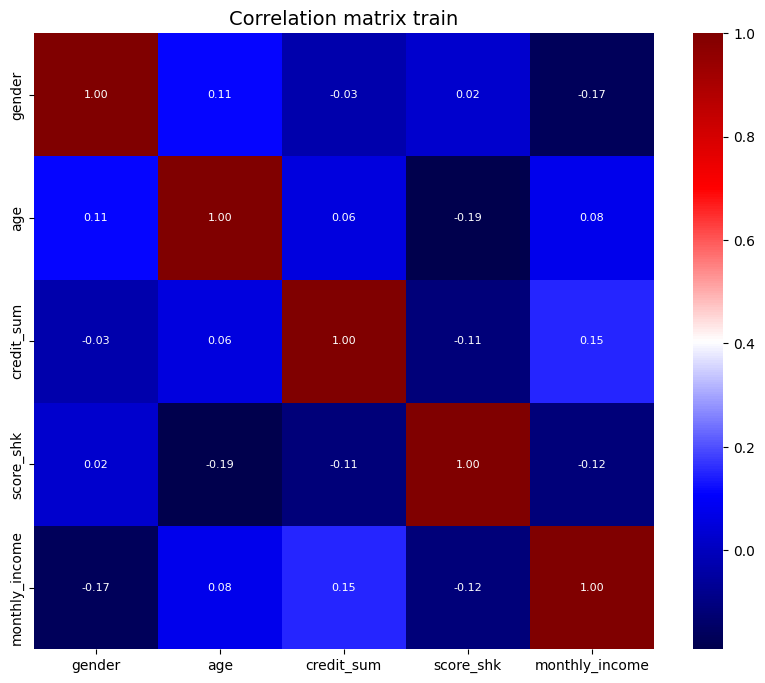

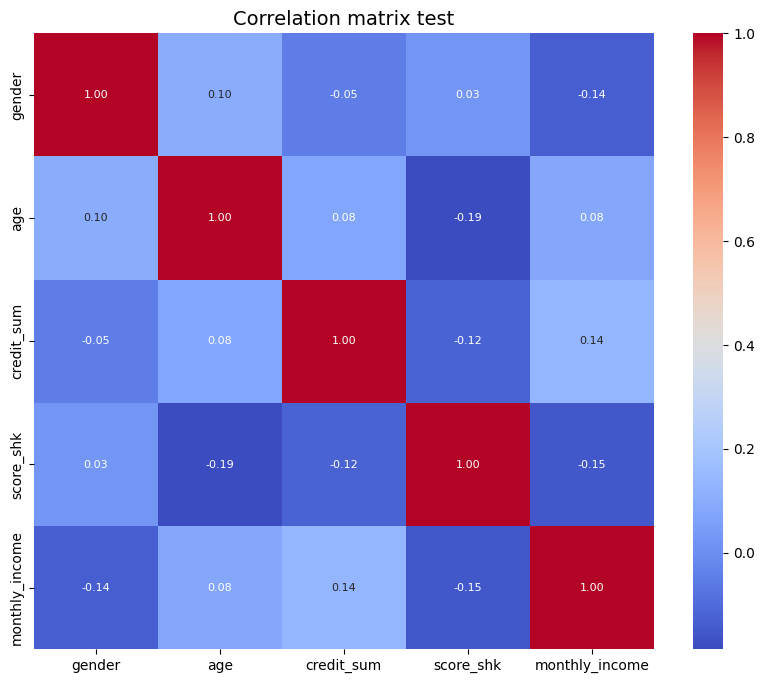

In [414]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = dataframe_for_corr_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, fmt='.2f', annot = True, cmap = 'seismic', annot_kws={"fontsize":8}) # cmap: 'seismic', 'coolwarm', YlGnBu", "Blues", "coolwarm", "BuPu", "Greens", "Oranges", "Reds", "Purples", "YlOrBr"
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title("Correlation matrix train", fontsize = 14)
plt.savefig('CorrMatrix_train.png') 
plt.show()

corr = dataframe_for_corr_test.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, fmt='.2f', annot = True, cmap = 'coolwarm', annot_kws={"fontsize":8}) # cmap: 'seismic', 'coolwarm', YlGnBu", "Blues", "coolwarm", "BuPu", "Greens", "Oranges", "Reds", "Purples", "YlOrBr"
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title("Correlation matrix test", fontsize = 14)
plt.savefig('CorrMatrix_test.png') 
plt.show()

In [415]:
conn.close()

В данной работе проведено изучение работы со структурированным языком запросов в Python с помощью библиотеки sqlite3.
Продемонстрированы примеры использования основных конструкций языка.
Тренировочная таблица загружена из файла csv, разделена на тренировочную и тестовую выборки, сохранена как база данных с двумя таблицами, и далее с ней проводились операции поиска и замены значений с помощью операторов SQL. Кроме того, из БД были загружены колонки числовых данных и построены корреляционные матрицы для тренировочного и тестового набора.
Результирующие матрицы, как и ожидалось, похожи.